In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
pip install fuzzywuzzy

In [5]:
%cd /content/drive/MyDrive/cycling

/content/drive/MyDrive/cycling


# Helper Functions

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

def preprocess_data(file_path, numeric_column):

    data = pd.read_csv(file_path)
    print("Original shape:", data.shape)

    # Original numeric column distribution
    if numeric_column in data.columns:
        data[numeric_column].hist()
        plt.title(f'Original {numeric_column} Distribution')
        plt.show()

        # Removing NaN values and filtering numeric column
        lower_threshold = 180 #
        upper_threshold = 2300
        data = data[(data[numeric_column] < upper_threshold) &
                    (data[numeric_column].notna()) &
                    (data[numeric_column] > lower_threshold)]

        data = data[data['Start station'].notna() & (data['Start station'] != '')]

        data[numeric_column].hist()
        plt.title(f'Post-Cleaning {numeric_column} Distribution')
        plt.show()

        # Handling outliers
        Q1 = data[numeric_column].quantile(0.25)
        Q3 = data[numeric_column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        data = data[(data[numeric_column] >= lower_bound) & (data[numeric_column] <= upper_bound)]
    else:
        print(f"Column '{numeric_column}' not found in the dataset.")

    return data


In [ ]:
def add_duration_columns(df, duration_column):

    # Convert duration from seconds to minutes and hours
    df['Durations_minutes'] = df[duration_column] / 60000
    #df['Duration_hours'] = df[duration_column] / 3600
    df['Duration_hours'] = df['Durations_minutes'] / 60
    df['Durations_minutes'] = df['Durations_minutes'].round(2)
    df['Duration_hours'] = df['Duration_hours'].round(2)

    return df



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
def generic_eda(dataframe, numeric_column, chunk_size=10000):

    # Initialize accumulators
    total_daily_values = pd.Series(dtype=float)
    total_hourly_values = pd.Series(dtype=float)
    total_value = 0
    count = 0


    def process_chunk(chunk):
        chunk = chunk.copy()
        # Convert date columns to datetime
        # chunk['Start Date'] = pd.to_datetime(chunk['Start Date'], format='%Y-%m-%d %H:%M')
        # chunk['End Date'] = pd.to_datetime(chunk['End Date'], format='%Y-%m-%d %H:%M')
        chunk['Start Date'] = pd.to_datetime(chunk['Start Date'], format='%d/%m/%Y %H:%M')
        chunk['End Date'] = pd.to_datetime(chunk['End Date'], format='%d/%m/%Y %H:%M')


        # Extract date and hour for further analysis
        chunk['Start Day'] = chunk['Start Date'].dt.date
        chunk['Start Hour'] = chunk['Start Date'].dt.hour

        # Aggregations
        daily_values = chunk.groupby('Start Day')[numeric_column].sum()
        hourly_values = chunk.groupby('Start Hour')[numeric_column].sum()
        average_value = chunk[numeric_column].mean()

        return daily_values, hourly_values, average_value

    # Chunking the dataframe and processing each chunk
    num_chunks = len(dataframe) // chunk_size + (1 if len(dataframe) % chunk_size else 0)
    for i in range(num_chunks):
        chunk = dataframe[i * chunk_size:(i + 1) * chunk_size]
        daily_values, hourly_values, average_value = process_chunk(chunk)

        # Accumulate results
        total_daily_values = total_daily_values.add(daily_values, fill_value=0)
        total_hourly_values = total_hourly_values.add(hourly_values, fill_value=0)
        total_value += average_value * len(chunk)
        count += len(chunk)

    plot_results(total_daily_values, total_hourly_values, numeric_column)
    plot_weekday_month_analysis(total_daily_values)

    overall_average_value = total_value / count



    return total_daily_values, total_hourly_values, overall_average_value



def plot_results(daily_values, hourly_values, numeric_column):
    # Daily Values Plot
    plt.figure(figsize=(10, 6))
    daily_values.plot(kind='line', color='skyblue')
    plt.title(f'Daily {numeric_column} Values')
    plt.xlabel('Date')
    plt.ylabel(f'Sum of {numeric_column}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Hourly Values Plot
    plt.figure(figsize=(10, 6))
    hourly_values.plot(kind='line', color='green', marker='o')
    plt.title(f'Hourly {numeric_column} Values')
    plt.xlabel('Hour of the Day')
    plt.ylabel(f'Sum of {numeric_column}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_weekday_month_analysis(daily_values):
    df = daily_values.to_frame(name="Value")
    df.index = pd.to_datetime(df.index)

    df['Weekday'] = df.index.day_name()
    df['Month'] = df.index.month_name()

    # Group by month and weekday
    grouped = df.groupby(['Month', 'Weekday']).sum().reset_index()

    # Sorting the weekdays and months in order
    weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    months = ["January", "February", "March", "April", "May", "June",
              "July", "August", "September", "October", "November", "December"]
    grouped['Weekday'] = pd.Categorical(grouped['Weekday'], categories=weekdays, ordered=True)
    grouped['Month'] = pd.Categorical(grouped['Month'], categories=months, ordered=True)
    grouped = grouped.sort_values(['Month', 'Weekday'])

    pivot_table = grouped.pivot("Month", "Weekday", "Value")

    # Plotting the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_table, cmap="YlGnBu", annot=True, fmt=".0f")
    plt.title('Heatmap of Aggregated Values by Weekday for Each Month')
    plt.xlabel('Weekday')
    plt.ylabel('Month')
    plt.yticks(rotation=0)
    plt.show()


In [ ]:
def plot_top_stations_by_duration(df, station_column, duration_column, top_n=20):


    total_duration_by_station = df.groupby(station_column)[duration_column].sum()


    top_stations = total_duration_by_station.sort_values(ascending=False).head(top_n)


    plt.figure(figsize=(12, 8))
    top_stations.plot(kind='bar')
    plt.title(f'Top {top_n} Stations by Total {duration_column}')
    plt.xlabel('Station')
    plt.ylabel('Total Duration')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_top_stations_by_count(df, station_column, top_n):

    # Count transactions per station
    transaction_counts = df[station_column].value_counts().head(top_n)

    plt.figure(figsize=(12, 8))
    transaction_counts.plot(kind='bar')
    plt.title(f'Top {top_n} Stations by Transaction Count')
    plt.xlabel('Station')
    plt.ylabel('Number of Transactions')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
#Transfomration

import pandas as pd

def process_data(df, date_column, category_column, numeric_column):

    df[date_column] = df[date_column].str[:10]

    # Convert the category column to category type
    df[category_column] = df[category_column].astype('category')


    grouped_df = df.groupby([date_column, category_column])[numeric_column].sum().reset_index()

    return grouped_df


In [ ]:
from fuzzywuzzy import process

def find_matches(unique_stations, coordinates_names):
    matches = {}
    for station in unique_stations:
        match = process.extractOne(station, coordinates_names, score_cutoff=80)
        if match:
            matches[station] = match[0]
    return matches

def apply_matches(row, matches):
    return matches.get(row['Start station'], None)

def fuzzy_match_and_merge(monthly_station_totals, coordinates):

    unique_stations = monthly_station_totals['Start station'].unique()


    unique_coordinates = coordinates.drop_duplicates(subset='NAME')

    # Get unique names from the processed coordinates DataFrame
    coordinates_names = unique_coordinates['NAME'].unique()


    matches = find_matches(unique_stations, coordinates_names)

    # Map the closest matches to the original dataset
    monthly_station_totals['closest_start_station_name'] = monthly_station_totals.apply(apply_matches, matches=matches, axis=1)

    # Merge with coordinates
    merged = pd.merge(monthly_station_totals, unique_coordinates, left_on='closest_start_station_name', right_on='NAME', how='left')


    final_df = merged[['Start Date', 'Duration_hours', 'Start station', 'x', 'y']]


    final_df = final_df.drop_duplicates(subset=['Start Date', 'Duration_hours', 'Start station'])

    return final_df



In [ ]:
import plotly.express as px
import numpy as np

def plot_station_durations(dataframe, size_factor=10, plot_height=600, plot_width=800):
    df = dataframe.copy()


    if 'x' not in df.columns or 'y' not in df.columns:
        raise ValueError("The dataframe must contain 'x' and 'y' columns")


    station_durations = df.groupby(['Start station', 'x', 'y']).agg({'Duration_hours': 'sum'}).reset_index()

    # Apply logarithmic scale to
    station_durations['log_duration'] = np.log(station_durations['Duration_hours'] + 1)
    station_durations['log_duration_normalized'] = station_durations['log_duration'] / station_durations['log_duration'].max()


    station_durations['size'] = np.sqrt(station_durations['log_duration_normalized']) * size_factor


    fig = px.scatter(station_durations, x='x', y='y',
                     color='log_duration_normalized',
                     size='size',
                     hover_name='Start station',
                     color_continuous_scale=px.colors.sequential.Viridis,
                     labels={'log_duration_normalized': 'Normalized Log Total Duration'},
                     title='Total Station Durations (Log Scale) Indicated by Color')
    fig.update_layout(xaxis_title='Longitude', yaxis_title='Latitude',
                      height=plot_height, width=plot_width)

    fig.show()

In [ ]:
def analyze_top_stations(df, start_date, end_date):

    df['Start Date'] = pd.to_datetime(df['Start Date'])
    df['End Date'] = pd.to_datetime(df['End Date'])


    df_filtered = df[(df['Start Date'] >= start_date) & (df['Start Date'] < end_date)]
    start_station_counts = df_filtered['Start station'].value_counts()
    end_station_counts = df_filtered['End station'].value_counts()

    # Get the top 20 stations for start and end
    top_start_stations = start_station_counts.head(20)
    top_end_stations = end_station_counts.head(20)
    comparison_df = pd.DataFrame({'Start Station': top_start_stations, 'End Station': top_end_stations})


    comparison_df = comparison_df.fillna(0)

    comparison_df['Total'] = comparison_df['Start Station'] + comparison_df['End Station']
    comparison_df = comparison_df.sort_values(by='Total', ascending=False)
    comparison_df[['Start Station', 'End Station']].plot(kind='bar', figsize=(15, 8))
    plt.title(f'Top 20 Stations: Comparison of Start and End Station Popularity from {start_date} to {end_date}')
    plt.xlabel('Station')
    plt.ylabel('Count')
    plt.show()

# **Preporcessind and EDA**

In [ ]:
coordinates =  pd.read_csv('/content/drive/MyDrive/cycling/Stations_20180921.csv')

## Read and Preprocess

Original shape: (10703988, 9)


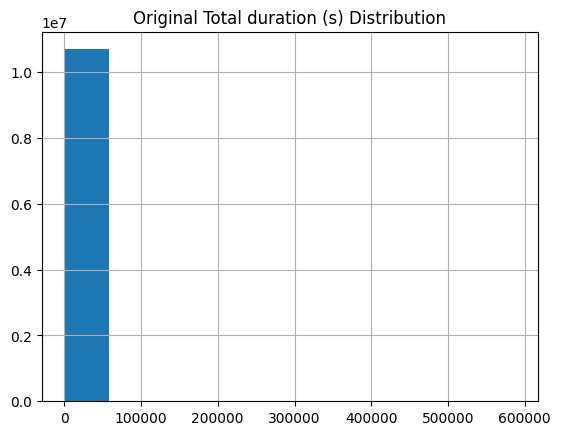

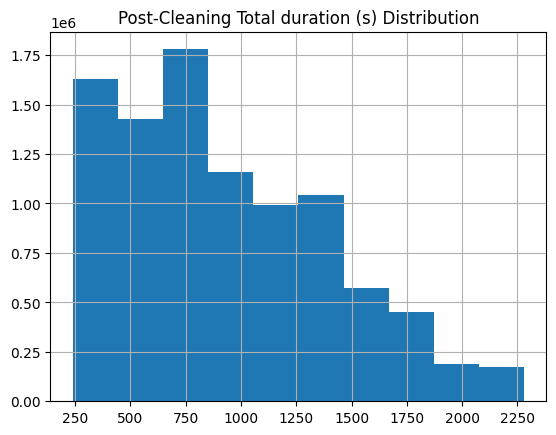

In [ ]:
#data_2021 = preprocess_data('2021/all_data_2021.csv', 'Total duration (s)')

<ipython-input-32-3dcdba7f135a>:12: DtypeWarning: Columns (3,5,6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


Original shape: (11426406, 9)


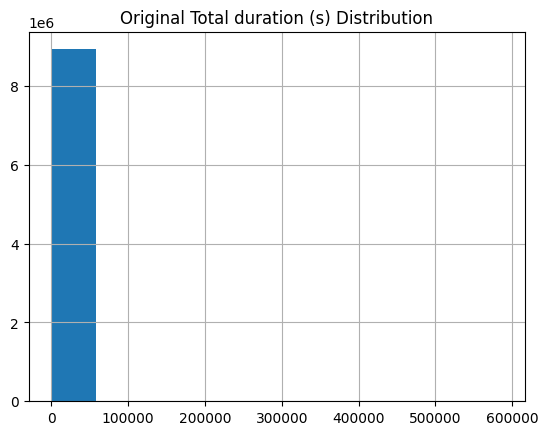

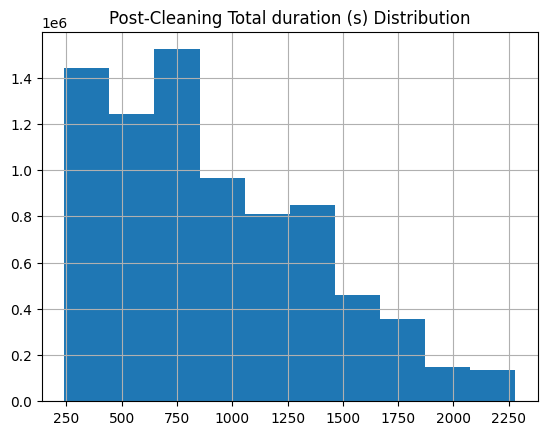

In [ ]:
#data_2022 = preprocess_data('2022/all_data_2022.csv', 'Total duration (s)')

<ipython-input-5-6cba7adf0c9b>:12: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


Original shape: (3843819, 11)


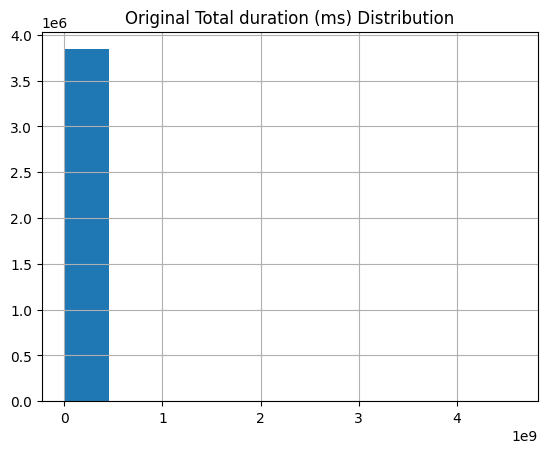

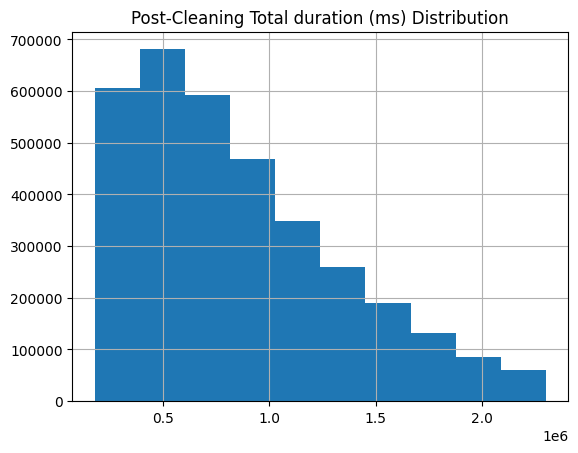

In [ ]:
#data_2023 = preprocess_data('2023/all_data_2023.csv', 'Total duration (ms)')

In [ ]:
# data_2021 = add_duration_columns(data_2021, 'Total duration (s)')
# data_2022 = add_duration_columns(data_2022, 'Total duration (s)')
##data_2023 = add_duration_columns(data_2023, 'Total duration (ms)')
# data_2023.rename(columns={'Start date': 'Start Date', 'End date': 'End Date'}, inplace=True)
data_2023.to_csv('2023/preprocesse_2023.csv', index = False)

In [ ]:
data_2023['Bike model'].unique()

array(['CLASSIC', 'PBSC_EBIKE'], dtype=object)

# **Reading the Preprocessed Data and EDA**

In [2]:
# data_2021 = pd.read_csv('2021/preprocesse_2021.csv')
# data_2022 = pd.read_csv('2022/preprocesse_2022.csv')
# data_2023 = pd.read_csv('2023/preprocesse_2023.csv')

<ipython-input-2-f1a6bdde26b9>:3: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  data_2023 = pd.read_csv('2023/preprocesse_2023.csv')


   Month  Total Duration (Hours)
0      1               115377.94
1      2               125765.09
2      3               128950.46
3      4               133276.74
4      5               172717.68
5      6               109571.98
6     12                 9610.49
Month                         33.00
Total Duration (Hours)    795270.38
dtype: float64


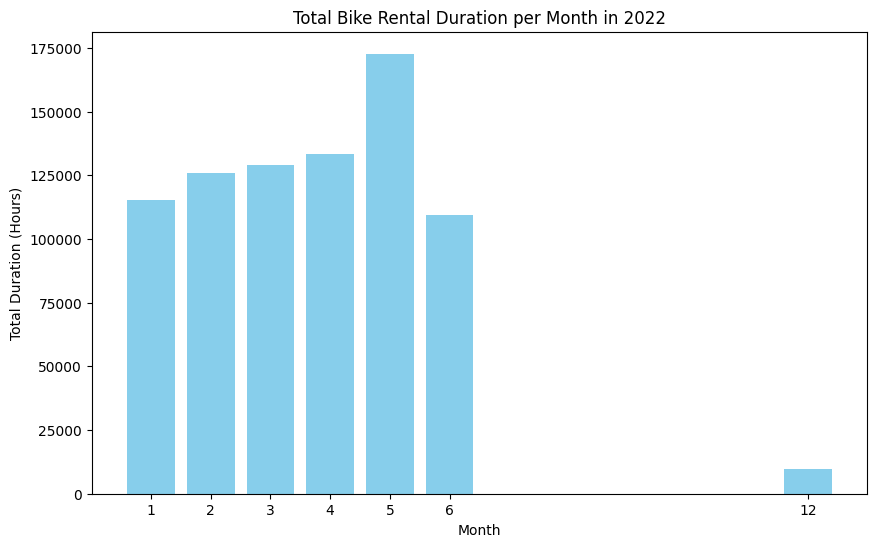

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data_2023['Start Date'] = pd.to_datetime(data_2023['Start Date'], format='%Y-%m-%d %H:%M')
data_2023['End Date'] = pd.to_datetime(data_2023['End Date'], format='%Y-%m-%d %H:%M')


data_2023['Month'] = data_2023['Start Date'].dt.month


monthly_duration = data_2023.groupby('Month')['Duration_hours'].sum()

monthly_duration_df = pd.DataFrame({'Month': monthly_duration.index, 'Total Duration (Hours)': monthly_duration.values})


print(monthly_duration_df)
print(monthly_duration_df.sum())

plt.figure(figsize=(10, 6))
plt.bar(monthly_duration.index, monthly_duration.values, color='skyblue')
plt.xlabel('Month')
plt.ylabel('Total Duration (Hours)')
plt.title('Total Bike Rental Duration per Month in 2022')
plt.xticks(monthly_duration.index)
plt.show()


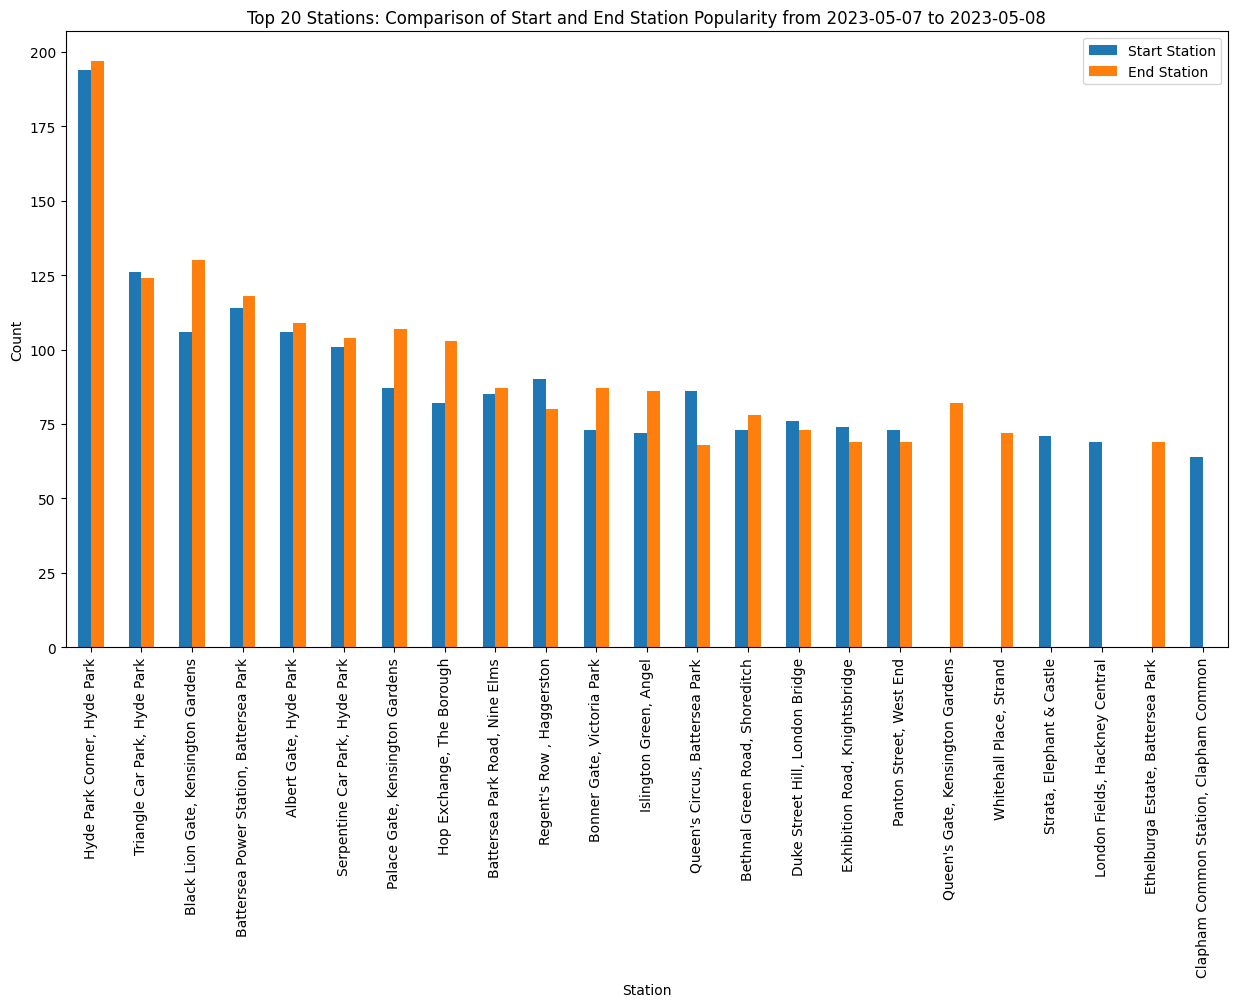

In [ ]:
analyze_top_stations(data_2023, '2023-05-07', '2023-05-08')

<ipython-input-56-fc99a0e196f4>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



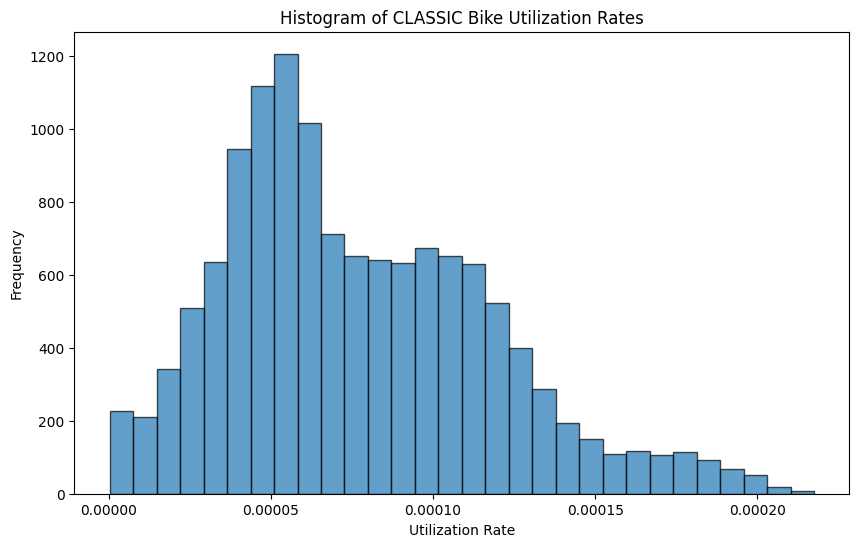

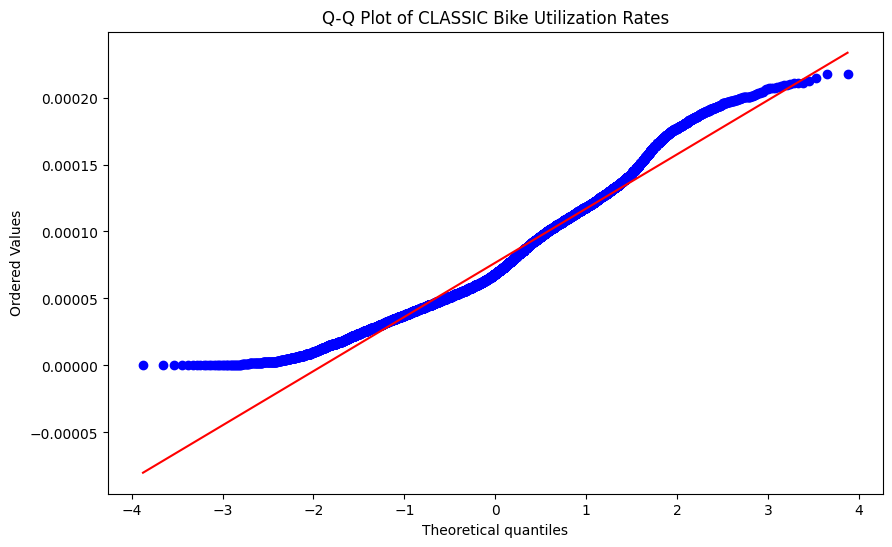

In [ ]:
import scipy.stats as stats

classic_bikes = data_2023[data_2023['Bike model'] == 'CLASSIC']
classic_bikes['Bike number'] = classic_bikes['Bike number'].astype(str)
bike_usage_counts = classic_bikes['Bike number'].value_counts()
bike_utilization = bike_usage_counts / bike_usage_counts.sum()

plt.figure(figsize=(10, 6))
plt.hist(bike_utilization, bins=30, edgecolor='black', alpha=0.7)
plt.title('Histogram of CLASSIC Bike Utilization Rates')
plt.xlabel('Utilization Rate')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
stats.probplot(bike_utilization, dist="norm", plot=plt)
plt.title('Q-Q Plot of CLASSIC Bike Utilization Rates')
plt.show()


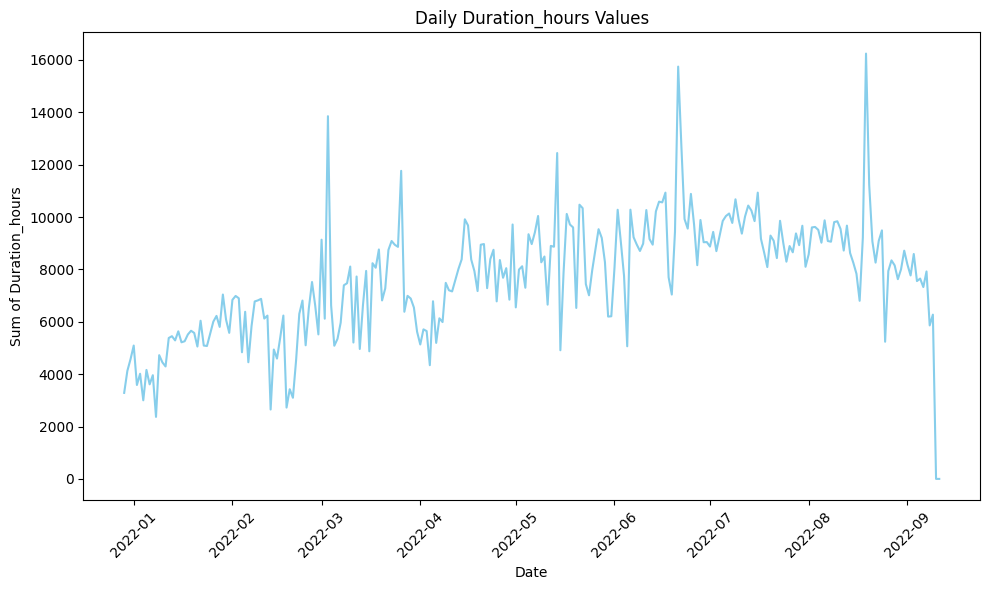

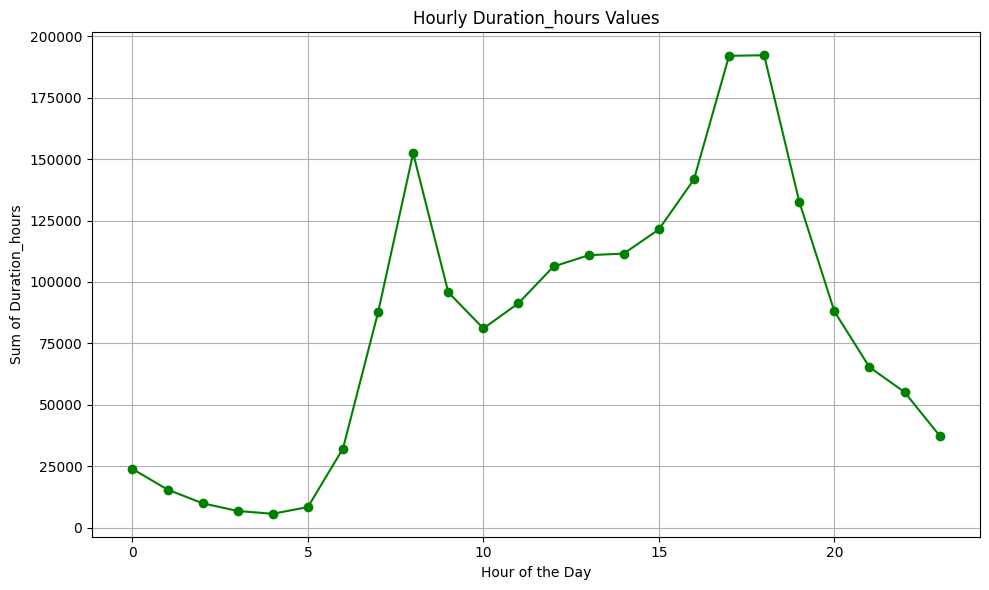

<ipython-input-109-a752c5b60f6c>:119: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table = grouped.pivot("Month", "Weekday", "Value")


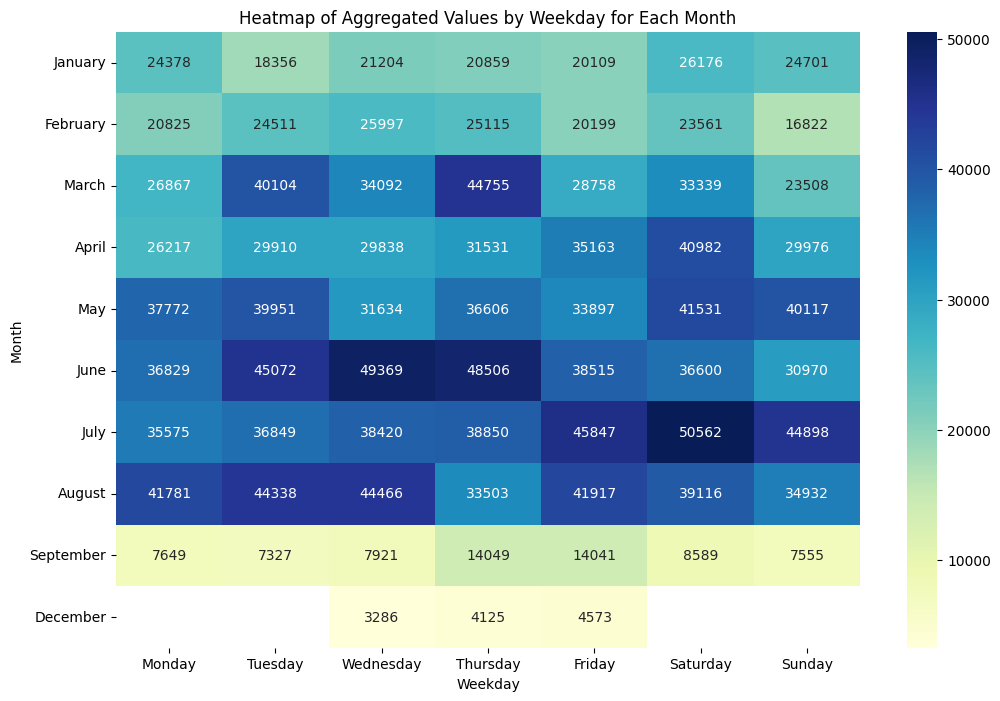

In [ ]:
total_daily_values, total_hourly_values, overall_average_value = generic_eda(data_2022, 'Duration_hours')

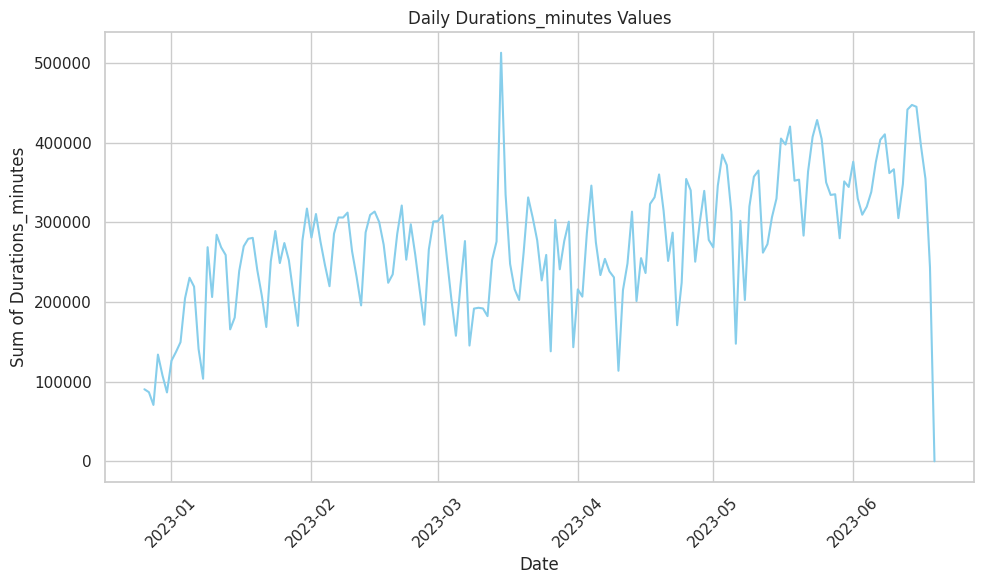

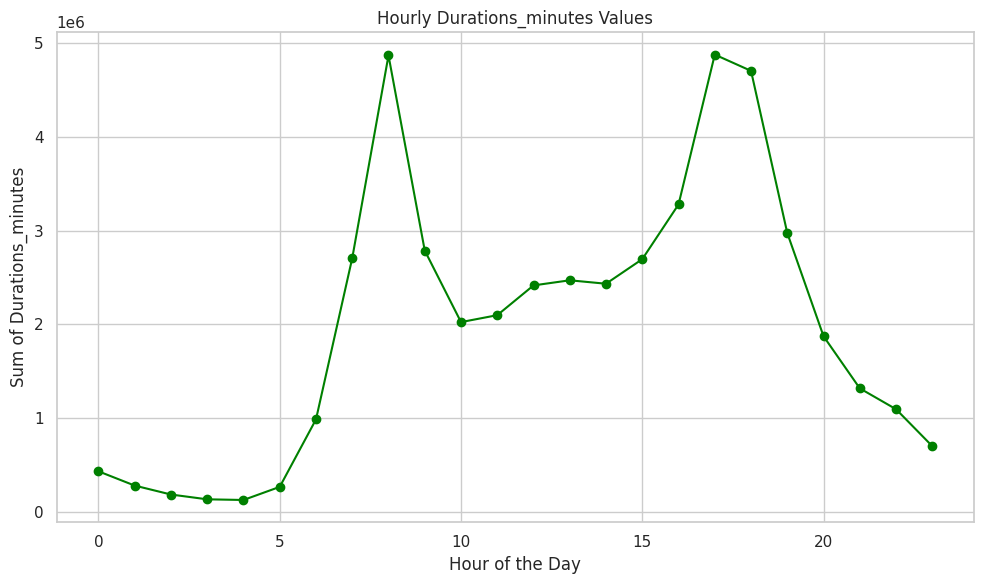

<ipython-input-131-69fd86e4d447>:115: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table = grouped.pivot("Month", "Weekday", "Value")


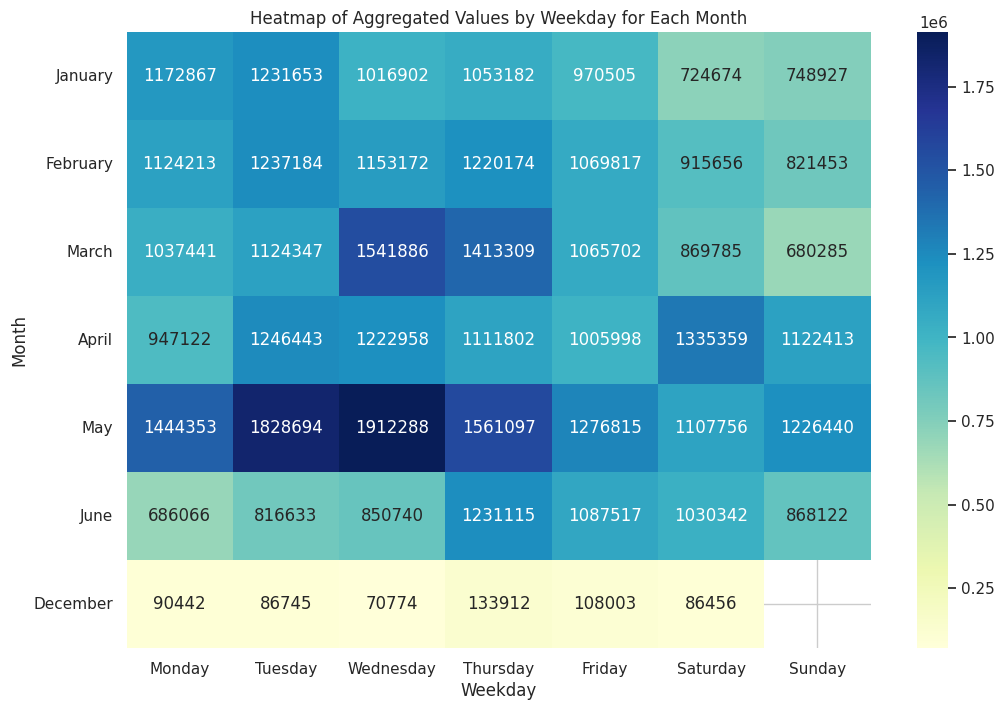

14.057940499169314


In [ ]:
total_daily_values, total_hourly_values, overall_average_value = generic_eda(data_2023, 'Durations_minutes', 10000)
print(overall_average_value)

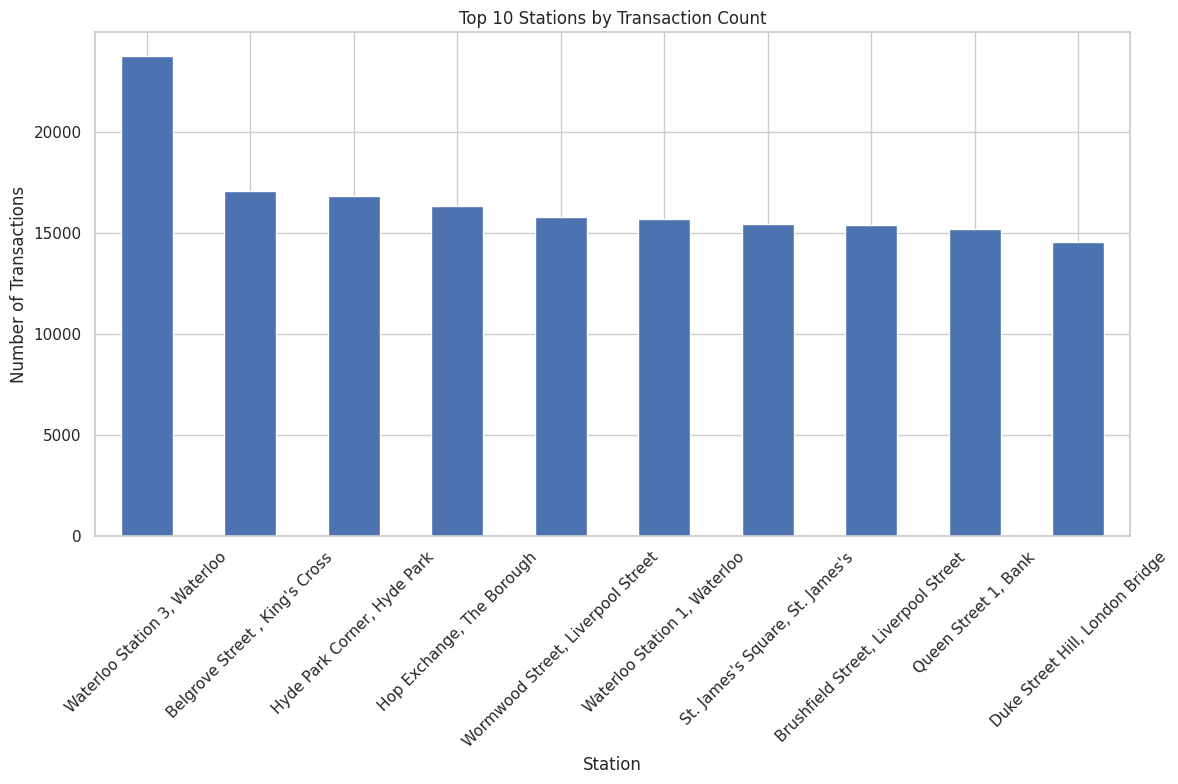

In [ ]:
plot_top_stations_by_count(data_2023, 'End station', 10)

Number of unique bike models: 2

Total Duration_hours per bike model:
Bike model
CLASSIC       734643.03
PBSC_EBIKE     60109.54
Name: Duration_hours, dtype: float64


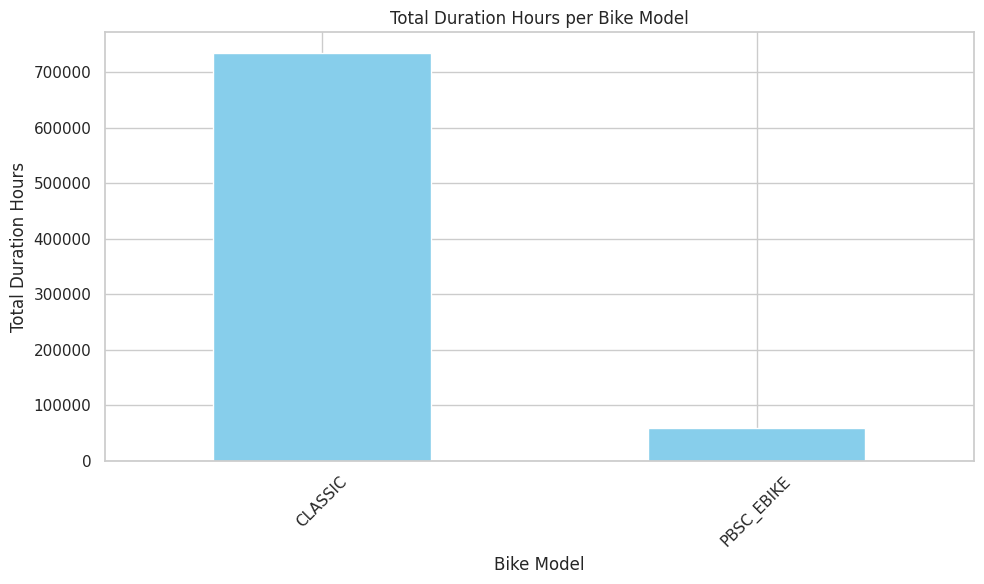

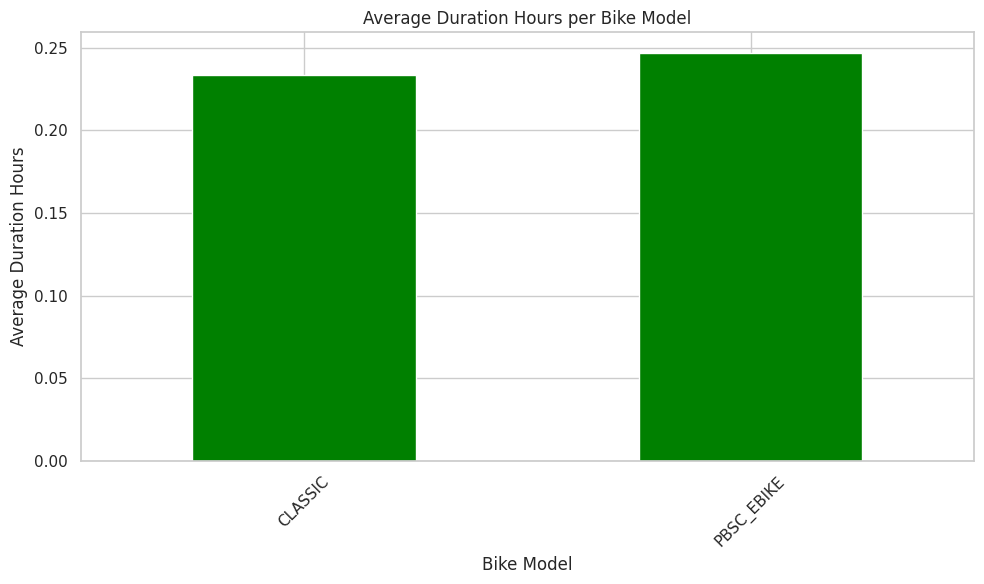

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
unique_bike_models = data_2023['Bike model'].nunique()
print(f"Number of unique bike models: {unique_bike_models}")

total_duration_per_bike_model = data_2023.groupby('Bike model')['Duration_hours'].sum()


average_duration_per_bike_model = data_2023.groupby('Bike model')['Duration_hours'].mean()
print("\nTotal Duration_hours per bike model:")
print(total_duration_per_bike_model)


plt.figure(figsize=(10, 6))
total_duration_per_bike_model.plot(kind='bar', color='skyblue')
plt.title('Total Duration Hours per Bike Model')
plt.xlabel('Bike Model')
plt.ylabel('Total Duration Hours')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
average_duration_per_bike_model.plot(kind='bar', color='green')
plt.title('Average Duration Hours per Bike Model')
plt.xlabel('Bike Model')
plt.ylabel('Average Duration Hours')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Fuzzy Matching Coordinates

In [ ]:
data_aggregated_start = process_data(data_2022, 'Start Date', 'Start station', 'Duration_hours')

In [ ]:
# Assume monthly_station_totals and coordinates are already defined and contain the correct columns
full_dataset = fuzzy_match_and_merge(data_aggregated_start, coordinates)


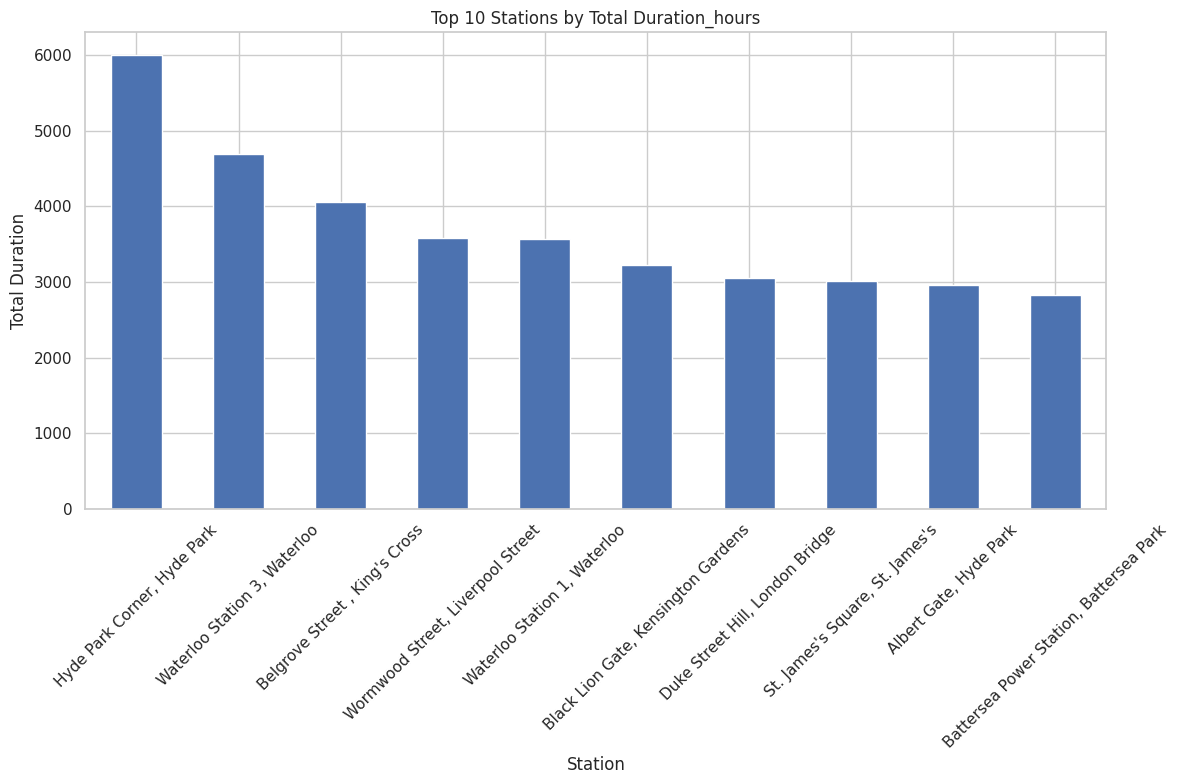

In [ ]:
plot_top_stations_by_duration(full_dataset, 'Start station', 'Duration_hours', 10)

In [ ]:
full_dataset.head()

,Start Date,Duration_hours,Start station,x,y
0,01/01/2022,7.46,"Abbey Orchard Street, Westminster",-0.124052,51.500453
1,01/01/2022,3.28,"Abbotsbury Road, Holland Park",-0.204063,51.506644
2,01/01/2022,4.75,"Aberdeen Place, St. John's Wood",-0.172545,51.534699
3,01/01/2022,1.51,"Aberfeldy Street, Poplar",-0.088801,51.510963
4,01/01/2022,16.16,"Abingdon Green, Westminster",-0.124052,51.500453


In [ ]:
#full_dataset.to_csv('full_processed_dataset_grouped_start_monthly_2022.csv')

In [ ]:
plot_station_durations(full_data, 10, 800, 1200)

In [ ]:
data_2023_cluster = data_2023[['Durations_minutes', 'Start station number', 'End station number']].iloc[-1000:]


# Clustering with K-means

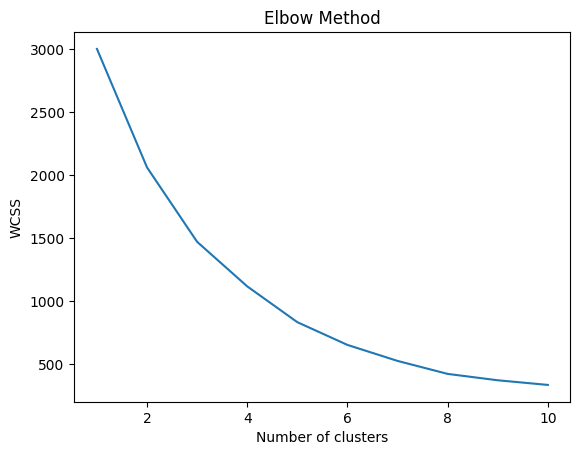

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


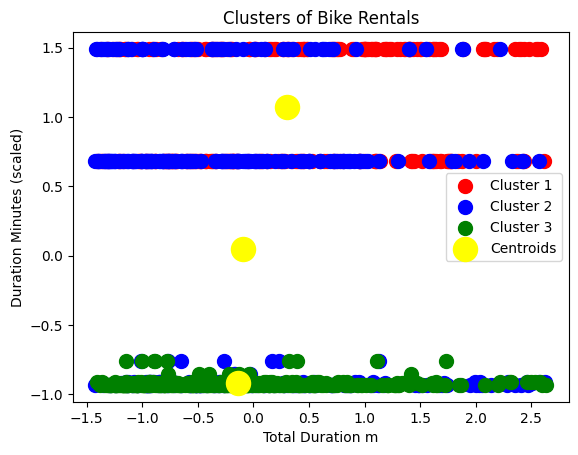

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


df = pd.DataFrame(data_2023_cluster)

# Scale the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Determine the number of clusters using Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)


plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') # within cluster sum of squares
plt.show()

kmeans = KMeans(n_clusters=3, random_state=0)
cluster_labels = kmeans.fit_predict(df_scaled)


plt.scatter(df_scaled[cluster_labels == 0, 0], df_scaled[cluster_labels == 0, 1], s=100, c='red', label ='Cluster 1')
plt.scatter(df_scaled[cluster_labels == 1, 0], df_scaled[cluster_labels == 1, 1], s=100, c='blue', label ='Cluster 2')
plt.scatter(df_scaled[cluster_labels == 2, 0], df_scaled[cluster_labels == 2, 1], s=100, c='green', label ='Cluster 3')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='yellow', label = 'Centroids')
plt.title('Clusters of Bike Rentals')
plt.xlabel('Total Duration m')
plt.ylabel('Duration Minutes (scaled)')
plt.legend()
plt.show()


# Time Series

In [18]:
full_data_2023 = pd.read_csv('full_processed_dataset_grouped_start_monthly_2023.csv')
full_data_2022 = pd.read_csv('full_processed_dataset_grouped_start_monthly_2022.csv')
full_data = pd.concat([full_data_2022, full_data_2023])

/content/drive/MyDrive/cycling


In [20]:
# First, ensure the 'Start Date' is in datetime format
full_data['Start Date'] = pd.to_datetime(full_data['Start Date'])

# Now, group by 'Start Date' and sum 'Duration_hours'
aggregated_data = full_data.groupby('Start Date')['Duration_hours'].sum().reset_index()


<ipython-input-20-11a69a55593d>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  full_data['Start Date'] = pd.to_datetime(full_data['Start Date'])


In [21]:
aggregated_data = aggregated_data.rename(columns={'Start Date': 'ds', 'Duration_hours': 'y'})


In [82]:
from prophet import Prophet
import pandas as pd

# Assuming 'aggregated_data' is your DataFrame and it has columns 'Start Date' and 'Duration_hours'
# We need to rename the columns for Prophet
df_prophet = data_2023_sample.rename(columns={'Start Date': 'ds', 'Duration_hours': 'y'})

# Split the data into training and validation sets
train = df_prophet.iloc[:200]
validation = df_prophet.iloc[200:]

In [83]:
train.shape

(200, 2)

In [84]:
# Initialize the Prophet model
model = Prophet(yearly_seasonality=True)

# Fit the model with the training dataset
model.fit(train)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl0f0hcsb/73l9jj0b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl0f0hcsb/b3klwow1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23785', 'data', 'file=/tmp/tmpl0f0hcsb/73l9jj0b.json', 'init=/tmp/tmpl0f0hcsb/b3klwow1.json', 'output', 'file=/tmp/tmpl0f0hcsb/prophet_model_p0b2oxi/prophet_model-20231114003025.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:30:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:30:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [85]:
# Predict
forecast = model.predict(validation)


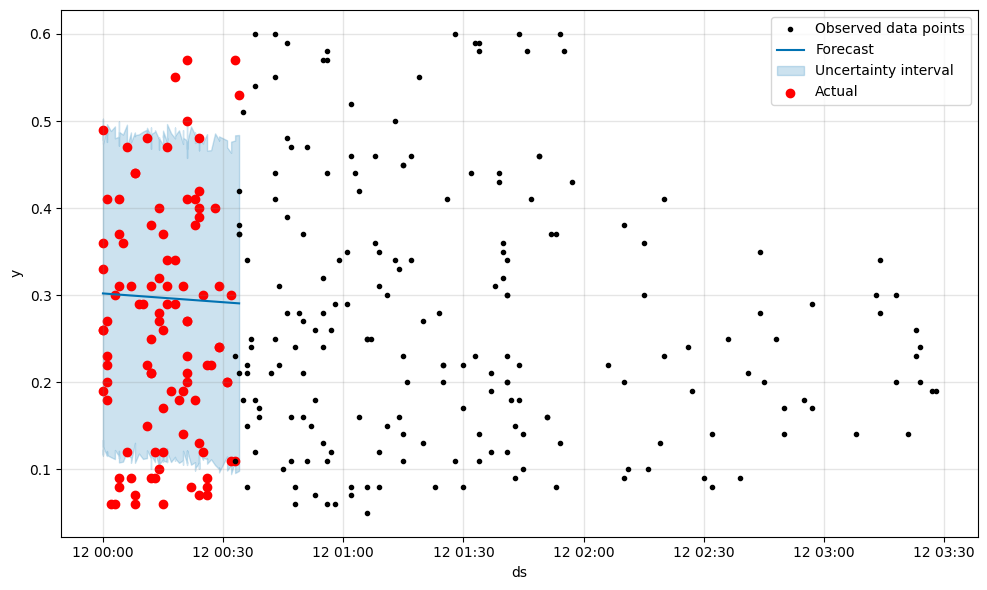

In [87]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt


# Predict using the model
forecast = model.predict(validation)

# Plot the forecast
fig1 = model.plot(forecast)

# Overlay the actual values from the validation set
plt.scatter(validation['ds'], validation['y'], color='r', label='Actual')

# Add legend to distinguish forecast and actuals
plt.legend()

plt.show()


In [5]:
data_2023_sample = data_2023.iloc[-300:]

In [54]:
data_2023_sample.shape


(300, 2)

In [7]:
data_2023_sample = data_2023_sample[['Start Date', 'Duration_hours']]

In [8]:
data_2023_sample


,Start Date,Duration_hours
3392056,2023-06-12 03:28:00,0.19
3392057,2023-06-12 03:27:00,0.19
3392058,2023-06-12 03:24:00,0.24
3392059,2023-06-12 03:24:00,0.20
3392060,2023-06-12 03:23:00,0.23
...,...,...
3392351,2023-06-12 00:00:00,0.19
3392352,2023-06-12 00:00:00,0.36
3392353,2023-06-12 00:00:00,0.26
3392354,2023-06-12 00:00:00,0.26
